# Projeto 3 - Ciência dos Dados

#### Stephanie Wertheimer, Thomas Pilnik e Victor Sznifer



# 1) Introdução
Nesse projeto, temos duas bases de dados: uma com dados laboratoriais a respeito quantidade de E. Coli presente na água das praias de Chicago, Illinois, EUA e outra que mensura diferentes características físicas da água, ambas em diferentes datas e horários. Elas estão disponíveis nos links:

https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

https://data.cityofchicago.org/Parks-Recreation/Beach-Lab-Data/2ivx-z93u

Nosso objetivo é buscar uma relação entre a proliferação de bactérias e os parâmetros físicos utilizados para analisar a água. Faremos isso usando um modelo de regressão linear e analisando a relação entre a concentração de bactérias e as diferentes variáveis físicas presentes na base de dados. 

A hipótese inicial (H0) é que as variáveis das características físicas da não água têm relação com a concentração de bactérias na água. Estatisticamente isso quer dizer que os betas na regressão linear são iguais a zero, ou seja, que não existe uma correlação. Portanto, nossa hipótese alternativa (H1) é de que as variáveis das características físicas da água têm relação com a concentração de bactérias na água, ou seja, que os betas na regressão linear são diferentes de zero. 
Pretendemos confirmar ou rejeitar nossa hipótese inicial por meio da regressão linear e teste de hipóteses que será feito a seguir.


$$H_0: \beta_i=0$$ $$nao $$ $$existe$$ $$relacao$$

$$H_1: \beta_i\neq0$$ $$existe$$$$relacao$$


In [1]:
#Importando diretórios

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import numpy as np
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


C:\Users\steph\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Abaixo fizemos as edições necessárias em nomes das células para conseguir fazer as alterações necessárias posteriormente para relacionar informações:

In [2]:
#Abrindo bases de dados
lab = pd.read_csv('Beach_Lab_Data.csv', sep=',')
water = pd.read_csv('Beach_Water_Quality_-_Automated_Sensors.csv', sep=',')

#Editando as colunas dos Data Frames

lab.columns = ["DNATestID", "Timestamp", "Beach", "DNA1","DNA2", "DNAMean", "CultureTestID","Sample1TimeStamp","Sample1Reading","Sample2Reading","ReadingMean","CultureNote","SampleInterval","Sample2TimeStamp","Latitude","Longitude","Location"]
water.columns = ["Beach", "Timestamp", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "BatteryLife","TimestampLabel","ID"]


#Selecionando as colunas do Date Frame 
lab = pd.DataFrame(lab.loc[:, ["Beach","ReadingMean","Sample1TimeStamp"]])
water=pd.DataFrame(water.loc[:, ["Beach", "WtrTemperature", "Turbidity", "WaveHeight", "WavePeriod", "TimestampLabel"]])

#Editando e padronizando o nome das praias

lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'South Shore'].index)
lab=lab.drop(lab[lab.Beach == '12th Street'].index)
lab=lab.drop(lab[lab.Beach == 'North Avenue'].index)
lab=lab.drop(lab[lab.Beach == 'Humboldt'].index)

lab['Sample1TimeStamp']=pd.to_datetime(lab.Sample1TimeStamp).dt.date

water=water.drop(water[water.Beach == 'Osterman Beach'].index)

water['Nível']='Médio'
water.loc[(water.Beach == "Montrose Beach"), "Nível"] = "Montrose"
water.loc[(water.Beach == "Calumet Beach"), "Nível"] = "Calumet"
water.loc[(water.Beach == "Ohio Street Beach"), "Nível"] = "Ohio Street"
water.loc[(water.Beach == "Rainbow Beach"), "Nível"] = "Rainbow"
water.loc[(water.Beach == "63rd Street Beach"), "Nível"] = "63rd Street"

del water['Beach']

#Padronizando data e hora do Data Frame de dados da água 

water['TimestampLabel']=pd.to_datetime(water.TimestampLabel).dt.date

Nossa base de dados teve as colunas filtradas de acordo com as variáveis que julgamos necessárias para fazer nossa análise.
No caso da base de dados de dados laboratoriais, decidimos que só era importante para nós analisar a média, e o horário. A medição que usamos para fazer as análises nesse sentido é a Reading Mean, dada em CPU.
CFU- Colony-Forming Unit

Em microbiologia, a CFU é usada para estimar o número de células de bactérias ou fungos viáveis em uma amostra. Ser viável significa ser capaz de se multiplicar por meio de fissão binária (mitose).

Já para as características físicas da água, decidimos analisar a Turbidez [Nephelometric Turbidity Units (NTU)] , Temperatura [ºC], Período da Onda [s] e Altura da Onda [m].

In [3]:
lab.head()

,Beach,ReadingMean,Sample1TimeStamp
0,NaN,239.3,2013-08-15
2,Hartigan,69.0,2010-06-02
5,Marion Mahony Griffin,7.1,2015-08-13
7,Marion Mahony Griffin,57.8,2007-08-17
8,Hartigan,10.8,2015-09-04


In [4]:
water.head()

,WtrTemperature,Turbidity,WaveHeight,WavePeriod,TimestampLabel,Nível
0,20.3,1.18,0.080,3.0,2013-08-30,Montrose
1,14.4,1.23,0.111,4.0,2016-05-26,Ohio Street
2,23.2,3.63,0.174,6.0,2013-09-03,Calumet
3,16.2,1.26,0.147,4.0,2014-05-28,Calumet
4,14.4,3.36,0.298,4.0,2014-05-28,Montrose


Para conseguir relacionar as informações das bases de dados, tivemos que usar o join. Precisávamos relacionar informações por meio de localização geográfica, ou seja, pelo nome da praia, e também pelo horário. Como precisávamos cruzar duas informações, usamos o módulo merge do pandas. 

In [5]:
#join e merge das duas bases de dados 

joined = lab.set_index('Beach').join(water.set_index('Nível'), how='inner', lsuffix='lab', rsuffix='_water')

new_df = pd.merge(lab, water,  how='inner', left_on=['Beach','Sample1TimeStamp'], right_on = ['Nível','TimestampLabel'])

new_df=new_df.dropna()
new_df= pd.DataFrame(new_df.loc[:, ['Beach','ReadingMean','Sample1TimeStamp','WtrTemperature','Turbidity','WaveHeight','WavePeriod','TimestampLabel']])

new_df = new_df.loc[(new_df.WaveHeight != -99999.992)]

new_df.head()

,Beach,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,WaveHeight,WavePeriod,TimestampLabel
629,Montrose,844.0,2016-08-05,22.7,0.0,0.093,4.0,2016-08-05
630,Montrose,844.0,2016-08-05,22.7,0.0,0.097,8.0,2016-08-05
631,Montrose,844.0,2016-08-05,22.7,0.0,0.097,7.0,2016-08-05
632,Montrose,844.0,2016-08-05,22.6,0.0,0.091,5.0,2016-08-05
633,Montrose,844.0,2016-08-05,22.6,0.0,0.101,10.0,2016-08-05


Abaixo estão plotados gráficos de dispersão que relacionam cada característica física da água, no eixo das abcissas, com a medição, em CFU, da quantidade de bactérias, nas ordenadas. Para cada gráfico fizemos um redimensionamento dos eixos, unicamente para melhorar a visualização dos pontos plotados no gráfico. Além disso também calculou-se a correlação entre cada característica e a proliferação de bactérias.

# 2) Dispersão/Correlação da Variavel Y em função das Variáveis Independentes 

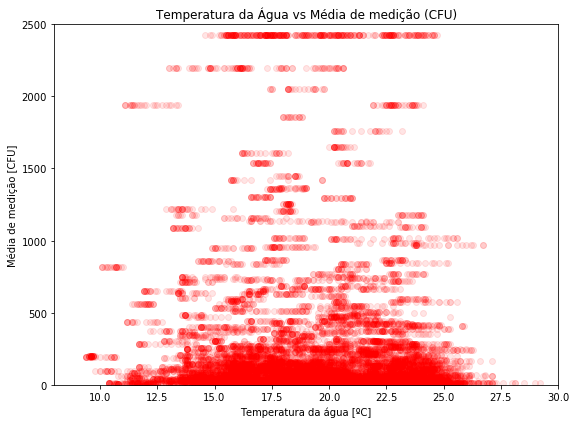

In [6]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WtrTemperature, new_df.ReadingMean, c='red', alpha=0.1)
plt.title('Temperatura da Água vs Média de medição (CFU)')
plt.ylabel('Média de medição [CFU]')
plt.xlabel('Temperatura da água [ºC]')


plt.tight_layout()
plt.axis([8,30,0,2500,])
plt.show()

In [7]:
print("Correlação entre temperatura da água e média de medição de bactérias: ", np.corrcoef(new_df.ReadingMean,new_df.WtrTemperature)[0,1])

Correlação entre temperatura da água e média de medição de bactérias:  -0.0483937905427


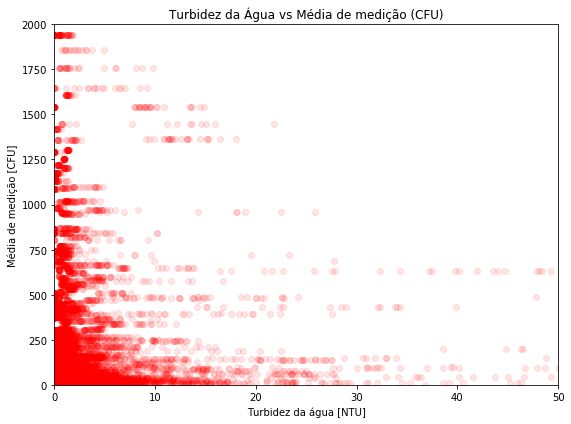

In [8]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.Turbidity, new_df.ReadingMean,  c='red', alpha=0.1)
plt.title('Turbidez da Água vs Média de medição (CFU)')
plt.ylabel('Média de medição [CFU]')
plt.xlabel('Turbidez da água [NTU]')


plt.tight_layout()
plt.axis([0,50,0,2000])
plt.show()

In [9]:
print("Correlação entre turbidez da água e média de medição de bactérias: ", np.corrcoef(new_df.ReadingMean,new_df.Turbidity)[0,1])

Correlação entre turbidez da água e média de medição de bactérias:  -0.0225959216439


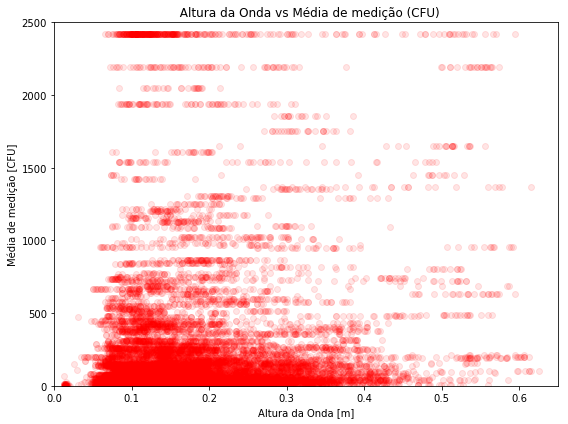

In [10]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WaveHeight, new_df.ReadingMean, c='red', alpha=0.1)
plt.title('  Altura da Onda vs Média de medição (CFU)')
plt.ylabel('Média de medição [CFU]')
plt.xlabel('Altura da Onda [m]')
plt.axis([0,0.65,0,2500])

plt.tight_layout()
plt.show()

In [11]:
print("Correlação entre altura da onda e média de medição de bactérias: ",np.corrcoef(new_df.ReadingMean,new_df.WaveHeight)[0,1])

Correlação entre altura da onda e média de medição de bactérias:  0.136859735272


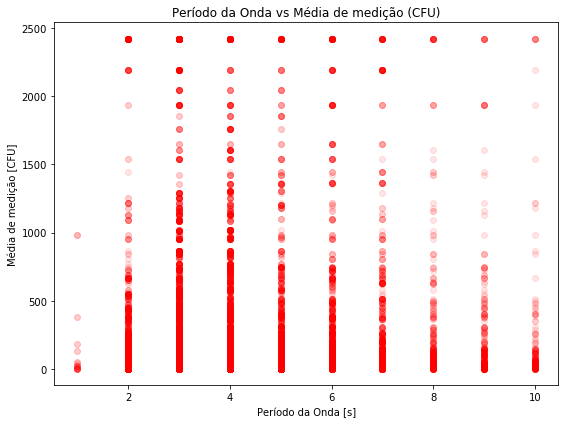

In [12]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WavePeriod, new_df.ReadingMean,  c='red', alpha=0.1)
plt.title('Período da Onda vs Média de medição (CFU)')
plt.ylabel('Média de medição [CFU]')
plt.xlabel('Período da Onda [s]')


plt.tight_layout()
plt.show()

In [13]:
print("Correlação entre período da onda e média de medição de bactérias: ",np.corrcoef(new_df.ReadingMean,new_df.WavePeriod)[0,1])

Correlação entre período da onda e média de medição de bactérias:  0.0749611506626


Analisando os gráficos qualitativamente, é possível concluir que nenhuma das variáveis físicas plotadas parece ter relação com a concentração de bactérias na água, pelo menos não em duas dimensões. Os coeficientes de correlação também indicam uma correlação baixíssima. Ainda assim, para confirmar se podemos ou nao rejeitar H0, que indica que as variáveis das características físicas da água não têm relação com a concentração de bactérias na água, vamos fazer um modelo de regressão linear.

# 3) Regressão Linear


Vamos usar a função OLS() da biblioteca statsmodel

In [14]:
#rodando função OLS() da biblioteca statsmodel

Y = new_df['ReadingMean']
X = new_df[['WtrTemperature','Turbidity','WaveHeight','WavePeriod']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ReadingMean   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     120.8
Date:                Tue, 21 Nov 2017   Prob (F-statistic):          5.90e-102
Time:                        21:09:58   Log-Likelihood:            -1.3975e+05
No. Observations:               18556   AIC:                         2.795e+05
Df Residuals:                   18551   BIC:                         2.795e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const            110.1474     22.709      4.850      0.000        65.635   154.660
WtrTemperature    -3.3543      0.966     -3.473      0.001        -5.247    -1.461
Turbidity         -0.5415      0.103     -5.276      0.000        -0.743    -0.340
WaveHeight       659.9825     36.089     18.288      0.000       589.245   730.721
WavePeriod        18.3985      2.048      8.984      0.000        14.384    22.413
==============================================================================
Omnibus:                    12753.923   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141522.956
Skew:                           3.330   Prob(JB):                         0.00
Kurtosis:                      14.777   Cond. No.                         371.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Os resultados da nossa regressão linear, extraídos da tabela, podem ser vistos abaixo:

$$\hat\beta_0 = 110.1474$$

$$\hat\beta_1 = -3.3543$$

$$\hat\beta_2 = -0.5415$$

$$\hat\beta_3 = 659.9825$$

$$\hat\beta_4 = 18.3985$$

Analisando esses valores, é possível perceber que nenhum vale exatamente 0, ou seja, nenhum valor nos leva a confirmar H0, mas será necessário fazer um teste de hipótese para ver se os devem ser rejeitados por serem muito improváveis de ocorrer, ou se  não devem ser rejeitados. Vamos fazer esse teste de hipótese a seguir.

Abaixo estão listados, extraídos da tabela, o valor-p de cada Beta:

#### Beta 0: 

Valor-p: 0.000


#### Beta 1: 

Valor-p: 0.001



#### Beta 2: 

Valor-p: 0.000



#### Beta 3: 

Valor-p: 0.000


#### Beta 4: 

Valor-p: 0.000


Percebe-se que os valores-p são extremamente pequenos. Abaixo, um valor com mais casas decimais foi calculado:

In [15]:
print(results.pvalues)

const             1.242853e-06
WtrTemperature    5.156832e-04
Turbidity         1.335660e-07
WaveHeight        4.650796e-74
WavePeriod        2.857141e-19
dtype: float64


Considerando os valores-p calculados, é possível perceber que é extremamente improvável que os valores de beta calculados aconteçam. Considerando um alfa com sensibilidade de 1% ou até menor, os valores-p nos levam a rejeitar H0. Dessa forma, a conclusão é de que existe relação, ou seja, as variáveis das características físicas da água têm relação com a concentração de bactérias na água.

Apesar disso, a normal está muito deformada e assimétrica, então mesmo que rejeitemos H0 e consideremos que existe relação entre a quantidade de bactérias e características físicas da água, não podemos modelar a curva como sendo uma normal. Sinais de assimetria e deformação são, por exemplo, skew e kurtosis.


Skew é uma medida de assimetria. Com um valor de 3,330 indica uma "cauda" assimétrica com valores positivos, à direita, ou seja, com uma cauda maior para a direita. A distribuição normal ideal tem Skew = 0, e tem valores distribuídos igualmente à direita e à esquerda.

Kurtosis, por sua vez, é uma medida que indica a deformação do pico da distribuição. Com Kurtosis = 14.777, percebe-se que o pico da distribuição está muito mais elevado do que deveria estar em uma normal.


Ademais, para confirmar a falha gerada pelo modelo normal, é possível verificar como distribui-se a variável Y. De acordo com o Teorema do Limite Central, para um número n de amostras significativamente grande, a distribuição das amostras se aproxima da normal. Temos um n significativamente grande em nossa amostra, mas nem ela não se acomoda como uma normal abaixo será plotado um gráfico que mostra como a quantidade de bactérias se distribui: 


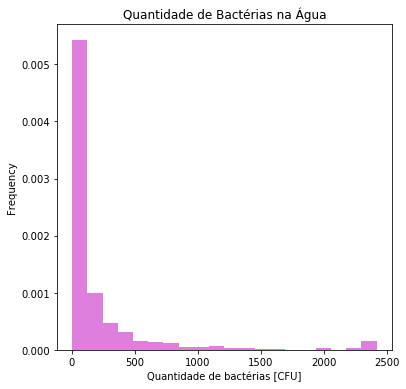

In [16]:
#plotagem gráficos

fig = plt.figure(figsize=(10, 8))
new_df.ReadingMean.plot.hist(bins=20,title='Quantidade de Bactérias na Água', figsize=(6, 6), normed=1, alpha=0.5, color='m')
plt.xlabel("Quantidade de bactérias [CFU]")

De fato, a quantidade de bactérias não segue uma distribuição normal.

Apesar de já termos percebido que essa modelagem é falha, vamos dividir a base de dados em duas: uma para treino (80% do total) e uma de teste para testar a efetividade do modelo (20% do total).

In [17]:
# definindo X como o dataframe com as colunas de variáveis independentes e y como a variável dependente

X = new_df.iloc[:,3:7]
y = new_df.iloc[:,1]

# divindo X e y em treinamento e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


# Criando objeto de regressão linear

regr = linear_model.LinearRegression()

# Treinando o modelo 

regr.fit(X_train, y_train)

# Usando a função predict para prever os valores de y

y_pred = regr.predict(X_test)

O gráfico abaixo mostra o y previsto em função do y teste encontrado. Ou seja, plota a correspondência de valores reais x valores simulados. Assim, o ideal seria que o gráfico formasse uma bissetriz, o que não acontece. Portanto, a previsão a partir da regressão linear não é suficiente para explicar o modelo.

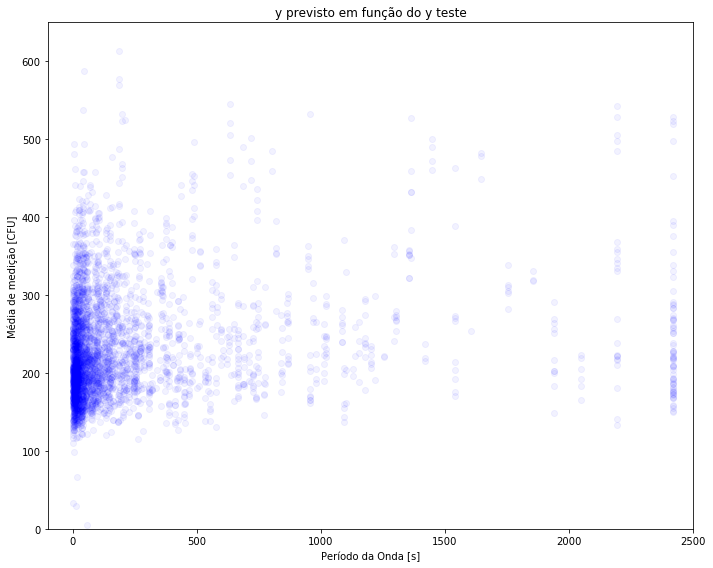

Correlação entre y previsto vs y teste:  0.18344359744


In [18]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred,  c='blue', alpha=0.05)
plt.title('y previsto em função do y teste')
plt.ylabel('Média de medição [CFU]')
plt.xlabel('Período da Onda [s]')
plt.tight_layout()
plt.axis([-100,2500,0,650])
plt.show()

print("Correlação entre y previsto vs y teste: ",np.corrcoef(y_test,y_pred)[0,1])

### Definindo a função MAPE (Erro Percentual da Média Absoluta)

Depois de fazer o treinamemnto da nossa base de dados, calculamos o erro percentual da média absoluta para testar a efetividade e quantificar o modelo. Para fazer isso, definimos a função MAPE abaixo.

In [19]:
# Função MAPE

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
print("Erro Percentual da Média Absoluta para a regressão linear",MAPE(y_test,y_pred))

Erro Percentual da Média Absoluta para a regressão linear 1338.58408266


Dessa forma, o coeficiente de correlação, o gráfico de dispersão, a deformidade da normal, o gráfico de distribuição da variável quantidade de bactérias, o percentual MAPE e o gráfico da previsão confirmam que não se pode modelar esse sistma a partir de uma normal e não se pode utilizar um modelo de regressão linear adequadamente. Por conta disso, uma segunda técnica de análise será abordada: uma Árvore de Decisão de Regressão.


# 4) Árvore de Decisão de Regressão


Da mesma forma que foi feito para o teste da regressão linear, a base de dados será manipulada para fazer o teste na árvore de decisão.

In [21]:
X = new_df.iloc[:,3:7]
y = new_df.iloc[:,1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Definindo a Árvore de Decisão de Regressão

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 5)

y_pred=dt.predict(X_test)

In [22]:
print("Erro Percentual da Média Absoluta para a Árvore de Decisão de Regressão: ",MAPE(y_test,y_pred))

Erro Percentual da Média Absoluta para a Árvore de Decisão de Regressão:  1095.33707477


O gráfico abaixo mostra o y previsto em função do y teste encontrado. Ou seja, plota a correspondência de valores reais x valores simulados. Assim, o ideal seria que o gráfico formasse uma bissetriz, o que acontece com alguns valores. Para valores mais baixos, é possível observar certa concentração de resultados, o que indica que o modelo funciona melhor do que o de regressão linear, apesar de ainda não ser o ideal.

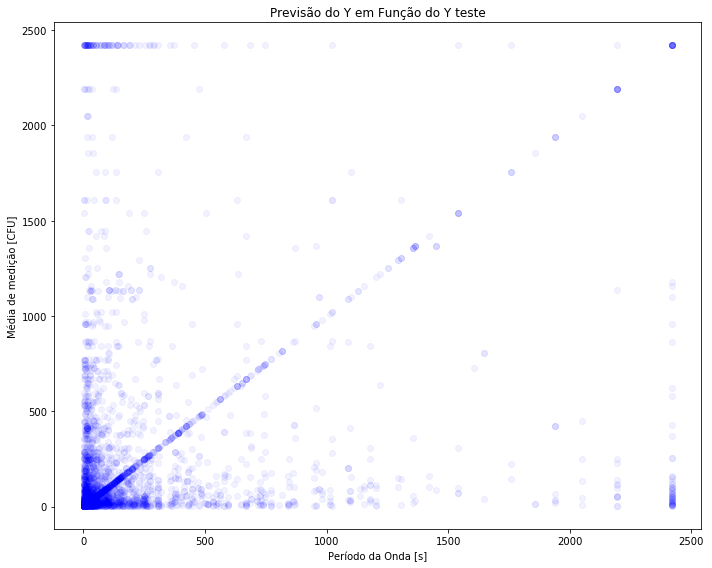

Correlação entre y previsto vs y teste:  0.251159089732


In [23]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred,  c='blue', alpha=0.05)
plt.title('Previsão do Y em Função do Y teste')
plt.ylabel('Média de medição [CFU]')
plt.xlabel('Período da Onda [s]')
plt.tight_layout()
plt.show()

print("Correlação entre y previsto vs y teste: ",np.corrcoef(y_test,y_pred)[0,1])

A correlação entre as variáveis nesse modelo é maior do que a da regressão linear, confirmando mais uma vez que a árvore de decisão explica de maneira mais eficaz o modelo comparado à regressão linear.

No gráfico abaixo, o eixo das abcissas representa o valor de X, ou seja, das variáveis independentes. O eixo das ordenadas representa a quantidade de bactérias, ou seja, y.

Em roxo, estão representados os pontos relacionando os valores de X reservados para a base de teste, assim como os valores de y previstos.

Em amarelo, estão representados os pontos relacionando os valores de X e y da base de dados original.

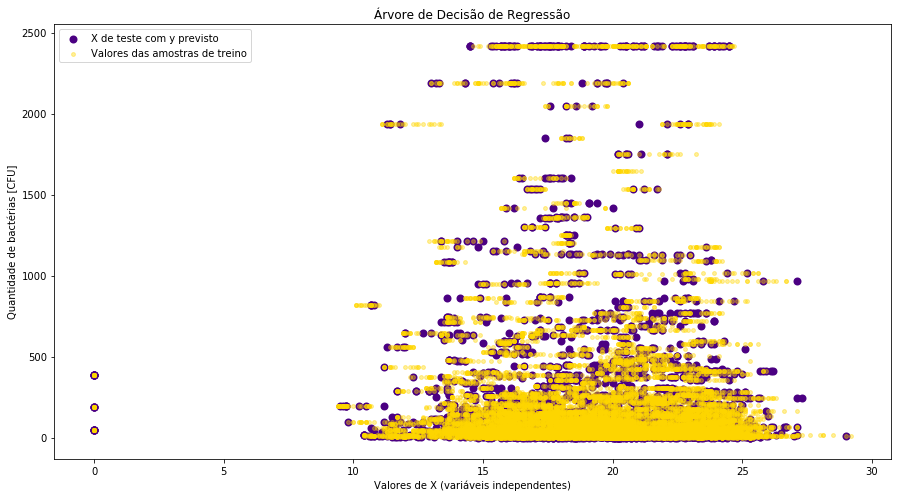

In [24]:
plt.figure(figsize=(15,8))
plt.scatter(X_test.iloc[:,0], y_pred, color="indigo", label="X de teste com y previsto", linewidth=2,alpha=1)
plt.scatter(X.iloc[:,0], y, s=15,c="gold", label="Valores das amostras de treino",alpha=0.4)
plt.xlabel("Valores de X (variáveis independentes)")
plt.ylabel("Quantidade de bactérias [CFU]")
plt.title("Árvore de Decisão de Regressão")
plt.legend()
plt.show()

Abaixo, o mesmo gráfico plotado anteriormente, utilizando uma escala que facilita a visualização dos dados.

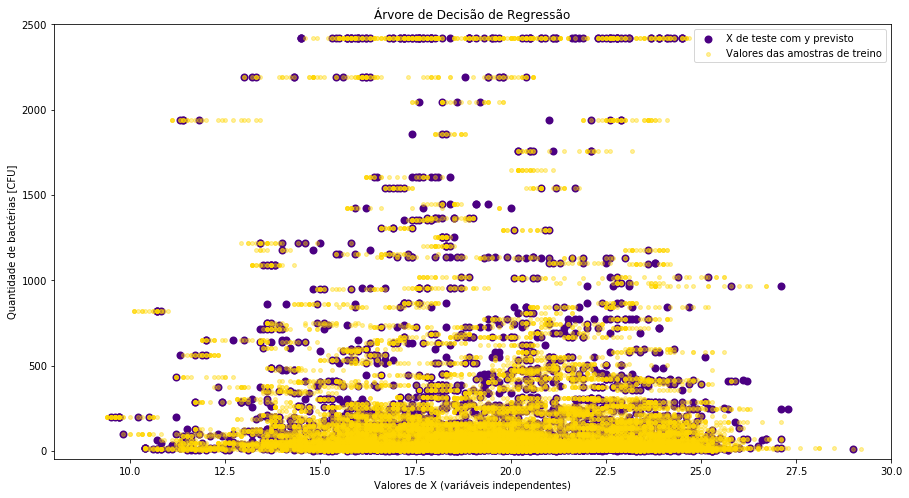

In [25]:
plt.figure(figsize=(15,8))
plt.scatter(X_test.iloc[:,0], y_pred, color="indigo", label="X de teste com y previsto", linewidth=2,alpha=1)
plt.scatter(X.iloc[:,0], y, s=15,c="gold", label="Valores das amostras de treino",alpha=0.4)
plt.xlabel("Valores de X (variáveis independentes)")
plt.ylabel("Quantidade de bactérias [CFU]")
plt.title("Árvore de Decisão de Regressão")
plt.legend()
plt.axis([8,30,-50,2500])
plt.show()

Observando os gráficos é possível perceber que a previsão de valores está relativamente precisa quando comparado aos valores originais da base de dados, mostrando maior efetividade do segundo modelo.

# 5) Comparando os Métodos de Modelagem e Conclusão

Comparando os métodos de modelagem, é possível concluir que a árvore é muito melhor do que a regressão linear para modelar esse sistema. O modelo de regressão linear foi descartado por diversas razões acima explicitadas, enquanto a árvore apresentou um grau de fidelidade à realidade muito maior, o que ficou claro nos gráficos de Árvore de Decisão de Regressão acima.

Comparando valores: 

Erro Percentual da Média Absoluta para a regressão linear 1338.58%
Erro Percentual da Média Absoluta para a Árvore de Decisão de Regressão:  1095.33%


Correlação entre y previsto vs y teste para a regressão:  0.18344359744
Correlação entre y previsto vs y teste para a árvore:  0.251159089732


A comparação dos valores de MAPE e Correlação acima permitem concluir que o erro da regressão linear é maior e a correlação é menor. Apesar de os valores mostrarem que a árvore de decisão é melhor, o erro percentual ainda é muito alto, e a correlação muito baixa. Isso nos permite concluir que nenhum dos dois métodos é ideal, mas a árvore é muito superior nesse caso.

Podemos concluir que em duas dimensões, as variáveis que imaginávamos ter relação com a quantidade de bactérias na água acabou se mostrando ausente em nossas análises, mas ainda assim fizemos um modelo onde o predict funcionou bem. 


### Melhorias para uma segunda iteração:

Para ter uma melhor interpretação de até aonde essas variáveis realmente não se comunicam, precisaríamos fazer um estudo onde as variáveis seriam fixadas duas por vez, ou seja, iríamos calcular a moda das variáveis temperatura e turbidez, por exemplo, e fixar um valor específico, para então entender o comportamento das outras duas variáveis. Faríamos isso alternando todas as possibilidades de combinação entre as variáveis indepentendes, para entender como cada uma se comporta em relação à outra. 

Poderíamos também oscilar as medidas. Por exemplo, a média de temperatura é aproximadamente 19.4°C. Se oscilácemos essa temperatura para cima e para baixo, nós iríamos observar como as bactérias e as outras variáveis se comportam diante disso. Fazendo isso com todas as variáveis, teríamos um maior entendimento de como o sistema realmente se comporta. Ele acabou se mostrando mais complexo do que o esperado, considerando que não pode ser modelado em uma regressão linear.

Observação: Para fazer os gráficos relativos a essa melhora, nós teríamos de ordenar a base de dados usando a função .sorted() em função da variável em análise, uma vez para cada variável, para termos gráficos realmente expressivos.

#### Relatório de trabalho individual: 

item 1 - Stephanie 

item 2 - Thomas (gerou gráficos), Victor (arrumou escala dos gráficos), Stephanie (gerou coeficiente de correlação)

item 3 - Stephanie (tabela, hipóteses, análise da normal, gráfico de distribuição de bactérias, treinamento), Thomas (predict, gráfico de variáveis independentes, função MAPE)

item 4 - Thomas (função MAPE, gráfico de variáveis independentes, predict, Árvore de Decisão de Regressão), Victor (Árvore de Decisão de Regressão, predict), Stephanie (treinamento, Árvore de Decisão de Regressão) 

item 5 - Thomas, Stephanie 

Stephanie, Thomas - todos os comentários de código e desenvolvimento do texto. 
